# Neural Network notebook
This file contains the structure of the neural network model to predict visibility of the new crescent moon.

In [241]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,precision_score, f1_score, recall_score

#pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

In [242]:
#bool variables to alter the code path
METHOD = False #add a seen_with_aid label, usually binary with seen and not_seen
USE_GPU = False #process using gpu
WEATHER = True #use the data set with cloud levels
QUIET = True #turn off print statements at epochs
REPEAT_ACCURACY = False #run the model several times then average the result
TEST_USE = True #run to evaluate on the test data, once you are satisfied with the model
early_stopping = True

In [243]:
#run processes on CPU or GPU
if USE_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cpu


## Read in data

In [244]:
#use the main data set or the cloud level set
if WEATHER:
    icouk_data_weather = '..\\Data\\cloud_data_distance_cut.csv'
    data = pd.read_csv(icouk_data_weather)
    data=data.drop(['Cloud Level','Distance'], axis = 1)
else:
    data_file = '../Data/moon_sighting_data.csv'
    data = pd.read_csv(data_file)

print(f"Loaded {data.shape[0]} rows")

#drop columns not needed to interpret visibility
data = data.drop(["Index","q","W","q'", 'Source'], axis = 1)

if METHOD:
    #drop multioutput style column and replace aid types with a seen_with_aid category
    data = data.drop(["Seen", "Methods"], axis = 1)
    data["Method"] = data["Method"].replace("Seen_binoculars", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_telescope", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_ccd", "Seen_with_aid")

    #names of the data labels
    ptype = [r"Seen_eye", r"Seen_with_aid", r"Not_seen"]
else:
    #drop sightings seen using aid
    data = data[data["Method"] !="Seen_binoculars"]
    data = data[data["Method"] !="Seen_ccd"]
    data = data[data["Method"] !="Seen_telescope"]
    
    data=data.drop(['Method','Methods'], axis = 1)

    ptype = [r"Seen", r"Not_seen"]

print(f"Selected {data.shape[0]} rows")

variable_list =  data.columns.tolist()

#scale dates to avoid the model favouring them
data['Sunset'] -= data['Date']
data['Moonset'] -= data['Date']
data['Date'] -= 2400000
data['Date'] *= 1/10000
data.drop(['Date','Sunset','Moonset'], axis=1)

Loaded 551 rows
Selected 499 rows


,Latitude,Longitude,Moon Age,Lag,Moon Alt,Moon Az,Sun Alt,Sun Az,Moon-Earth Dist,Sun-Moon Dist,ARCL,ARCV,DAZ,Illumination,Parallax,W',Seen,Visibility,Cloud cover
0,52.48142,-1.89983,0.935,39.51667,2.28332,241.76737,-3.34868,252.16322,0.00260,0.98474,11.81934,5.63200,10.39585,0.01060,56.29433,0.32539,Not_seen,0.0,0.750
1,51.62127,0.30556,0.931,39.48333,2.34983,242.27205,-3.40259,252.52998,0.00260,0.98474,11.75662,5.75242,10.25793,0.01049,56.29437,0.32196,Not_seen,0.0,0.750
2,51.45523,-2.59665,0.939,40.16667,2.41319,242.37016,-3.45872,252.66280,0.00260,0.98474,11.84551,5.87191,10.29264,0.01065,56.28682,0.32680,Not_seen,0.0,0.125
3,51.38333,-0.10000,0.932,39.70000,2.38350,242.40850,-3.43106,252.64678,0.00260,0.98474,11.76999,5.81456,10.23828,0.01051,56.29208,0.32269,Not_seen,0.0,0.750
4,51.50853,-0.12574,0.932,39.63333,2.36973,242.33670,-3.41905,252.58979,0.00260,0.98474,11.77020,5.78878,10.25310,0.01051,56.29274,0.32270,Not_seen,0.0,0.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,37.22966,-80.41368,1.210,26.75000,2.16557,249.05633,-3.17114,261.48968,0.00263,0.99461,13.52572,5.33671,12.43336,0.01387,55.72217,0.42132,Not_seen,0.0,1.000
545,35.77743,-5.80323,2.010,52.16667,4.62676,242.30325,-5.48297,262.86249,0.00261,0.99454,22.88592,10.10973,20.55923,0.03936,55.95593,1.20166,Seen,1.0,0.625
546,33.61687,-7.12304,2.016,54.98333,5.07406,242.91666,-5.86758,263.09150,0.00261,0.99454,22.92343,10.94163,20.17485,0.03949,55.92168,1.20496,Seen,1.0,0.750
549,43.85198,18.38669,28.594,-25.63333,-3.10041,269.76195,1.18343,257.93261,0.00267,0.99520,12.57697,4.28384,-11.82935,0.01200,54.72288,0.35745,Seen,1.0,0.875


In [245]:
data.head(10)

,Date,Latitude,Longitude,Moon Age,Sunset,Moonset,Lag,Moon Alt,Moon Az,Sun Alt,...,Sun-Moon Dist,ARCL,ARCV,DAZ,Illumination,Parallax,W',Seen,Visibility,Cloud cover
0,5.925823,52.48142,-1.89983,0.935,-0.012,0.015,39.51667,2.28332,241.76737,-3.34868,...,0.98474,11.81934,5.63200,10.39585,0.01060,56.29433,0.32539,Not_seen,0.0,0.750
1,5.925823,51.62127,0.30556,0.931,-0.012,0.016,39.48333,2.34983,242.27205,-3.40259,...,0.98474,11.75662,5.75242,10.25793,0.01049,56.29437,0.32196,Not_seen,0.0,0.750
2,5.925823,51.45523,-2.59665,0.939,-0.012,0.015,40.16667,2.41319,242.37016,-3.45872,...,0.98474,11.84551,5.87191,10.29264,0.01065,56.28682,0.32680,Not_seen,0.0,0.125
3,5.925823,51.38333,-0.10000,0.932,-0.012,0.015,39.70000,2.38350,242.40850,-3.43106,...,0.98474,11.76999,5.81456,10.23828,0.01051,56.29208,0.32269,Not_seen,0.0,0.750
4,5.925823,51.50853,-0.12574,0.932,-0.012,0.015,39.63333,2.36973,242.33670,-3.41905,...,0.98474,11.77020,5.78878,10.25310,0.01051,56.29274,0.32270,Not_seen,0.0,0.750
5,5.925823,51.50853,-0.12574,0.932,-0.012,0.015,39.63333,2.36973,242.33670,-3.41905,...,0.98474,11.77020,5.78878,10.25310,0.01051,56.29274,0.32270,Not_seen,0.0,0.750
6,5.925823,51.50853,-0.12574,0.932,-0.012,0.015,39.63333,2.36973,242.33670,-3.41905,...,0.98474,11.77020,5.78878,10.25310,0.01051,56.29274,0.32270,Not_seen,0.0,0.750
7,5.928725,51.62127,0.30556,0.318,0.000,-0.001,-1.96667,-0.72500,260.61628,-0.69739,...,0.99146,6.02473,0.02761,6.02513,0.00276,55.21359,0.08307,Not_seen,0.0,0.250
8,5.928725,51.46839,-0.36092,0.320,0.000,-0.001,-1.71667,-0.70691,260.64207,-0.71566,...,0.99146,6.03253,0.00875,6.03299,0.00277,55.21297,0.08328,Not_seen,0.0,0.250
9,5.928827,51.62127,0.30556,1.341,-0.021,0.026,66.83333,4.91236,262.05269,-5.43706,...,0.99180,15.26128,10.34941,11.23131,0.01763,54.61166,0.52541,Not_seen,0.0,1.000


In [246]:
if METHOD:
    #split the dataset into variables and labels
    y = np.array(data['Method'])
    variable_list.remove('Method')
    X = np.array(data[variable_list])

    #convert the labels to integers
    y[y == 'Seen_eye'] = int(2)
    y[y == 'Seen_with_aid'] = int(1)
    y[y == 'Not_seen'] = int(0)
else:
    y = np.array(data['Seen'])
    variable_list.remove('Seen')
    X = np.array(data[variable_list])

    y[y == 'Seen'] = int(1)
    y[y == 'Not_seen'] = int(0)

In [247]:
#hyperparameters for the NN
input_size = len(variable_list)
hidden_size = 20#32
learning_rate = 0.005
weight_decay = 0.01

if METHOD:
    output_size = 3
else:
    output_size = 2 

num_epochs = 250
batch_size = 60 #60

modfile = 'modfile.pt'

In [248]:
# Define the neural network model structure
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

In [249]:
#function to train the model on data
def train(model, trainloader, optimiser, device):
    train_loss = 0.0
    model.train()

    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)

        optimiser.zero_grad()

        #calculate train loss
        p_y = model(data)
        loss_criterion = nn.CrossEntropyLoss()
        labels = labels.type(torch.LongTensor) 
        labels = labels.to(device)
        loss = loss_criterion(p_y, labels)
            
        train_loss += loss.item() * data.size(0)

        #feed the loss back
        loss.backward()
        optimiser.step()

    train_loss /= len(trainloader.dataset)
    return train_loss

#function to test the model on data
def validate(model, testloader, device):
    prediction=[]
    target=[]
    py_ten=torch.empty((0,3), dtype=torch.float64)
    correct = 0
    test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(testloader):
            data, labels = data.to(device), labels.to(device)

            p_y = model(data)
            if METHOD:
                #tensor for probabilities, for ROC score
                py_ten = torch.cat((py_ten, p_y), 0)

            #calculate test loss
            loss_criterion = nn.CrossEntropyLoss()
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            loss = loss_criterion(p_y, labels)
                
            test_loss += loss.item() * data.size(0)
            
            #values for metrics
            preds = p_y.argmax(dim=1, keepdim=True)
            correct += preds.eq(labels.view_as(preds)).sum().item()
            prediction+=preds.squeeze(1).tolist()
            target+=labels.tolist()
        test_loss /= len(testloader.dataset)
        accuracy = correct / len(testloader.dataset)

        #calculate ROC score metric
        if METHOD:
            scale_prob = nn.Softmax(dim=1)(py_ten).numpy()
            roc_auc = roc_auc_score(np.array(target), scale_prob, multi_class="ovr")
            recall = recall_score(target, prediction, average='weighted')
            f1 = f1_score(target, prediction, average='weighted')
            precision = precision_score(target, prediction, average='weighted')
        else:
            roc_auc = roc_auc_score(target, prediction)
            recall = recall_score(target, prediction)
            f1 = f1_score(target, prediction)
            precision = precision_score(target, prediction)
    return test_loss, accuracy, roc_auc, prediction, target, recall, f1, precision

In [250]:
#function to run the entire model train/test loop
def run_func():
    #split the data into train, test and validation
    X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, y,test_size=0.3)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

    X_train_tensor = torch.from_numpy(X_train).float()
    Y_train_tensor = torch.from_numpy(Y_train.astype("float64")).float()

    X_val_tensor = torch.from_numpy(X_val).float()
    Y_val_tensor = torch.from_numpy(Y_val.astype("float64")).float()

    X_test_tensor = torch.from_numpy(X_test).float()
    Y_test_tensor = torch.from_numpy(Y_test.astype("float64")).float()

    trainset = TensorDataset(X_train_tensor, Y_train_tensor)
    valset = TensorDataset(X_val_tensor, Y_val_tensor)
    testset = TensorDataset(X_test_tensor, Y_test_tensor)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    #create the model
    model = CustomNN(input_size, hidden_size, output_size).to(device)

    #optimizer and learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)#0.005, #0.01
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=2, factor=0.9)

    #array to store metrics
    result_arr = np.zeros((num_epochs,8))

    _bestloss = 1.
    bestepoch = 0
    #NN learning
    for epoch in range(num_epochs):
    
        train_loss = train(model, train_loader, optimizer, device)
        val_loss, accuracy, roc_auc, prediction, target,  recall, f1, precision = validate(model, val_loader, device)
        
        scheduler.step(val_loss)

        if early_stopping and val_loss<_bestloss:
            _bestloss = val_loss
            torch.save(model.state_dict(), modfile)
            best_epoch = epoch
            cm = confusion_matrix(target, prediction,normalize = 'true')

        #set output row
        results = [epoch, train_loss, val_loss, accuracy, roc_auc,  recall, f1, precision]
        result_arr[epoch] = results

        #print epocch results
        if not QUIET:
            print('Epoch: {}, Validation Loss: {:4f}, Validation Accuracy: {:4f}'.format(epoch, val_loss, accuracy))
            print('Current learning rate is: {}'.format(optimizer.param_groups[0]['lr']))
    
    test_arr=[]
    if TEST_USE:
        #Test data run
        bestmodel=CustomNN(input_size, hidden_size, output_size).to(device)
        bestmodel.load_state_dict(torch.load('modfile.pt'))
        test_loss, test_accuracy, test_auc, prediction2,target2,  recall2, f12, precision2 = validate(bestmodel, test_loader, device)
        test_arr=[test_loss, test_accuracy, test_auc, prediction2,target2,  recall2, f12, precision2]

    if not early_stopping:
        torch.save(model.state_dict(), modfile)
        best_epoch = -1
        cm = confusion_matrix(target, prediction,normalize = 'true')

    return result_arr, cm, test_arr, best_epoch

In [251]:
#run the model
result_arr1, cm, test_arr, best_epoch = run_func()

c:\Users\Ezzy\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Training cycle

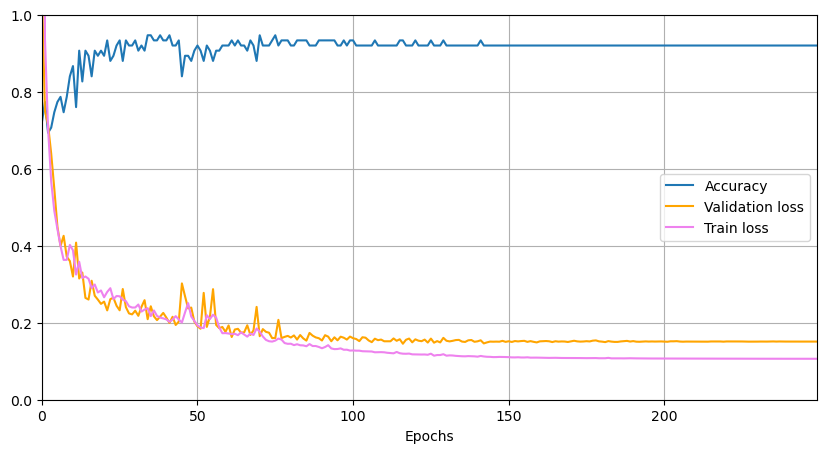

In [252]:
#plot the training cycle
plt.figure(figsize=(10,5))
plt.plot(result_arr1[:,0],result_arr1[:,3],linestyle='-', label='Accuracy')
plt.plot(result_arr1[:,0],result_arr1[:,2],linestyle='-', c='orange',label='Validation loss')
plt.plot(result_arr1[:,0],result_arr1[:,1],linestyle='-', c='violet',label='Train loss')
plt.ylim(0,1)
plt.xlim(0,num_epochs-1)
#plt.title('NN training cycle')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.show()

In [253]:
if TEST_USE:
    print(r'Final accuracy is {}'.format(test_arr[1]))
    print(r'ROC score is {}'.format(test_arr[2]))
else:
    print(r'Final accuracy is {}'.format(result_arr1[best_epoch,3]))
    print(r'ROC score is {}'.format(result_arr1[best_epoch,4]))

Final accuracy is 0.9066666666666666
ROC score is 0.8435672514619884


# Confusion matrix

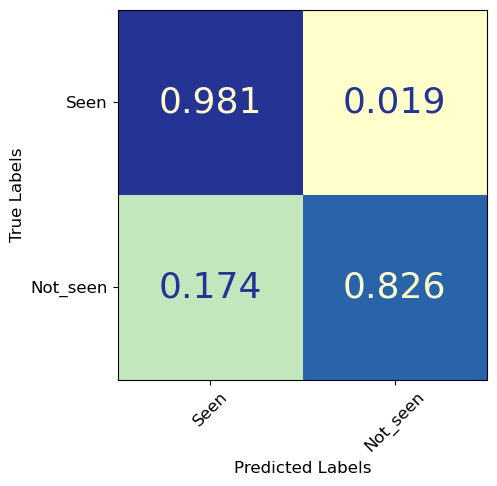

In [254]:
#plot the confusion matrix
# if TEST_USE:
#     cm = confusion_matrix(test_arr[3], test_arr[4],normalize = 'true')
# else:
#     cm = confusion_matrix(target, prediction,normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype)
colours = ['#ffffcc','#a1dab4','#41b6c4','#2c7fb8','#253494']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colours, N=20)
disp.plot(xticks_rotation=45,cmap = custom_cmap,values_format=".3f",colorbar=False) #values_format=".1%")
for labels in disp.text_.ravel():
    if METHOD:
        labels.set_fontsize(20)
    else:
        labels.set_fontsize(26)
fig = disp.figure_
ax = disp.ax_
ax.set_xlabel('Predicted Labels',fontsize=12)
ax.set_ylabel('True Labels',fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
fig = disp.figure_
# if TEST_USE:
#     plt.title(r"ANN {:.3}%".format(test_arr[1]*100))
# else:
#     plt.title(r"ANN {:.3}%".format(result_arr1[best_epoch,3]*100))
plt.show()

# Averaging accuracy

In [255]:
#run the model 20 times to get an average accuracy
if REPEAT_ACCURACY:
    acc_array =[]
    roc_arr =[]
    f1_arr=[]
    precision_arr=[]
    recall_arr=[]
    for i in range(20):
        result_arr_temp,_,test_arr,best_epoch = run_func()
        if TEST_USE:
            acc_array.append(test_arr[1])
            roc_arr.append(test_arr[2])
            recall_arr.append(test_arr[5])
            f1_arr.append(test_arr[6])
            precision_arr.append(test_arr[7])
        else:
            acc_array.append(result_arr_temp[best_epoch,3])
            roc_arr.append(result_arr_temp[best_epoch,4])
            recall_arr.append(result_arr_temp[best_epoch,5])
            f1_arr.append(result_arr_temp[best_epoch,6])
            precision_arr.append(result_arr_temp[best_epoch,7])
    print(r'The averaged accuracy is {:.3f} ± {:.3f}'.format(np.mean(acc_array),np.std(acc_array)))
    print(r'The averaged ROC score is {:.3f} ± {:.3f}'.format(np.mean(roc_arr),np.std(roc_arr)))
    print(r'The averaged recall score is {:.3f} ± {:.3f}'.format(np.mean(recall_arr),np.std(recall_arr)))
    print(r'The averaged precision score is {:.3f} ± {:.3f}'.format(np.mean(precision_arr),np.std(precision_arr)))
    print(r'The averaged f1 score is {:.3f} ± {:.3f}'.format(np.mean(f1_arr),np.std(f1_arr)))